<a href="https://colab.research.google.com/github/LisandroHdz/CHALLENGE_TELECOM_X/blob/main/CHALLLENGE1ETL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**1. Importación y Limpieza de Datos**
---



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Cargar los datos
df = pd.read_json('/content/TelecomX_Data.json')

# Mostrar estructura inicial
print(f"El dataset contiene {df.shape[0]} filas y {df.shape[1]} columnas")
print("\nPrimeras filas del dataset:")
print(df.head())

El dataset contiene 7267 filas y 6 columnas

Primeras filas del dataset:
   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            internet  \
0  {'InternetService': 'DSL', 'OnlineSecurity': '...   
1  {'InternetService': 'DSL', 'OnlineSecurity

**1.1. Verificación de datos**

In [2]:
# Verificar valores nulos
print("\nValores nulos por columna:")
print(df.isnull().sum())

# Verificar valores duplicados
print(f"\nNúmero de filas duplicadas: {df.duplicated().sum()}")

# Verificar valores inconsistentes en Churn
print("\nValores únicos en columna Churn:")
print(df['Churn'].value_counts(dropna=False))


Valores nulos por columna:
customerID    0
Churn         0
customer      0
phone         0
internet      0
account       0
dtype: int64


TypeError: unhashable type: 'dict'

**1.2. Limpieza y tratamiento de datos**

In [3]:
# Corregir valores vacíos en Churn (asumiremos que son 'No' para este análisis)
df['Churn'] = df['Churn'].replace('', 'No')

# Convertir Churn a binario (1 para 'Yes', 0 para 'No')
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Extraer datos anidados
def extract_nested_data(row, field, subfield):
    try:
        return row[field][subfield]
    except:
        return np.nan

# Extraer datos demográficos
df['gender'] = df.apply(lambda x: extract_nested_data(x, 'customer', 'gender'), axis=1)
df['SeniorCitizen'] = df.apply(lambda x: extract_nested_data(x, 'customer', 'SeniorCitizen'), axis=1)
df['Partner'] = df.apply(lambda x: extract_nested_data(x, 'customer', 'Partner'), axis=1)
df['Dependents'] = df.apply(lambda x: extract_nested_data(x, 'customer', 'Dependents'), axis=1)
df['tenure'] = df.apply(lambda x: extract_nested_data(x, 'customer', 'tenure'), axis=1)

# Extraer datos de teléfono
df['PhoneService'] = df.apply(lambda x: extract_nested_data(x, 'phone', 'PhoneService'), axis=1)
df['MultipleLines'] = df.apply(lambda x: extract_nested_data(x, 'phone', 'MultipleLines'), axis=1)

# Extraer datos de internet
internet_services = ['InternetService', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for service in internet_services:
    df[service] = df.apply(lambda x: extract_nested_data(x, 'internet', service), axis=1)

# Extraer datos de cuenta
account_data = ['Contract', 'PaperlessBilling', 'PaymentMethod']
for data in account_data:
    df[data] = df.apply(lambda x: extract_nested_data(x, 'account', data), axis=1)

df['MonthlyCharges'] = df.apply(lambda x: extract_nested_data(x['account'], 'Charges', 'Monthly'), axis=1)
df['TotalCharges'] = df.apply(lambda x: extract_nested_data(x['account'], 'Charges', 'Total'), axis=1)

# Convertir TotalCharges a numérico (algunos valores son strings)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Eliminar columnas anidadas originales
df = df.drop(['customer', 'phone', 'internet', 'account'], axis=1)

# Verificar datos después de la extracción
print("\nResumen después de la extracción:")
print(df.info())


Resumen después de la extracción:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   int64  
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   object 
 15  StreamingMovies   7267 non-null   object 
 16  Contrac

**1.3. Creación de nuevas columnas**

In [4]:
# Crear columna Cuentas_Diarias (DailyCharges)
df['DailyCharges'] = df['MonthlyCharges'] / 30

# Convertir variables categóricas a binarias
binary_columns = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_columns:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Para MultipleLines, considerar "No phone service" como 0
df['MultipleLines'] = df['MultipleLines'].map({'Yes': 1, 'No': 0, 'No phone service': 0})

# Para servicios de internet, considerar "No internet service" como 0
internet_services = internet_services[1:]  # excluir InternetService
for service in internet_services:
    df[service] = df[service].map({'Yes': 1, 'No': 0, 'No internet service': 0})

# Verificar transformaciones
print("\nResumen después de transformaciones:")
print(df.head())


Resumen después de transformaciones:
   customerID  Churn  gender  SeniorCitizen  Partner  Dependents  tenure  \
0  0002-ORFBO      0  Female              0        1           1       9   
1  0003-MKNFE      0    Male              0        0           0       9   
2  0004-TLHLJ      1    Male              0        0           0       4   
3  0011-IGKFF      1    Male              1        1           0      13   
4  0013-EXCHZ      1  Female              1        1           0       3   

   PhoneService  MultipleLines InternetService  ...  DeviceProtection  \
0             1              0             DSL  ...                 0   
1             1              1             DSL  ...                 0   
2             1              0     Fiber optic  ...                 1   
3             1              0     Fiber optic  ...                 1   
4             1              0     Fiber optic  ...                 0   

   TechSupport  StreamingTV  StreamingMovies        Contract  \
0 

**2. Análisis Exploratorio de Datos (EDA)**

**2.1. Análisis descriptivo**

In [5]:
# Estadísticas descriptivas para variables numéricas
print("\nEstadísticas descriptivas para variables numéricas:")
print(df[['tenure', 'MonthlyCharges', 'TotalCharges', 'DailyCharges']].describe())

# Distribución de variables categóricas
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                   'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                   'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                   'Contract', 'PaymentMethod']

print("\nDistribución de variables categóricas:")
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts(normalize=True) * 100)


Estadísticas descriptivas para variables numéricas:
            tenure  MonthlyCharges  TotalCharges  DailyCharges
count  7267.000000     7267.000000   7256.000000   7267.000000
mean     32.346498       64.720098   2280.634213      2.157337
std      24.571773       30.129572   2268.632997      1.004319
min       0.000000       18.250000     18.800000      0.608333
25%       9.000000       35.425000    400.225000      1.180833
50%      29.000000       70.300000   1391.000000      2.343333
75%      55.000000       89.875000   3785.300000      2.995833
max      72.000000      118.750000   8684.800000      3.958333

Distribución de variables categóricas:

gender:
gender
Male      50.571075
Female    49.428925
Name: proportion, dtype: float64

SeniorCitizen:
SeniorCitizen
0    83.734691
1    16.265309
Name: proportion, dtype: float64

Partner:
Partner
0    51.589377
1    48.410623
Name: proportion, dtype: float64

Dependents:
Dependents
0    69.987615
1    30.012385
Name: proportion, dtype

**2.2. Visualización de la distribución de Churn**

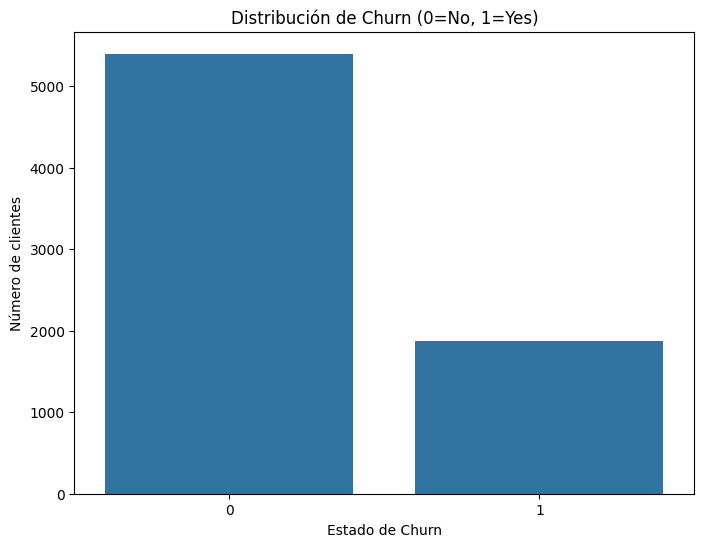


Tasa de Churn general: 25.72%


In [6]:
# Distribución de Churn
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=df)
plt.title('Distribución de Churn (0=No, 1=Yes)')
plt.xlabel('Estado de Churn')
plt.ylabel('Número de clientes')
plt.show()

# Porcentaje de Churn
churn_rate = df['Churn'].mean() * 100
print(f"\nTasa de Churn general: {churn_rate:.2f}%")

**2.3. Churn por variables categóricas**

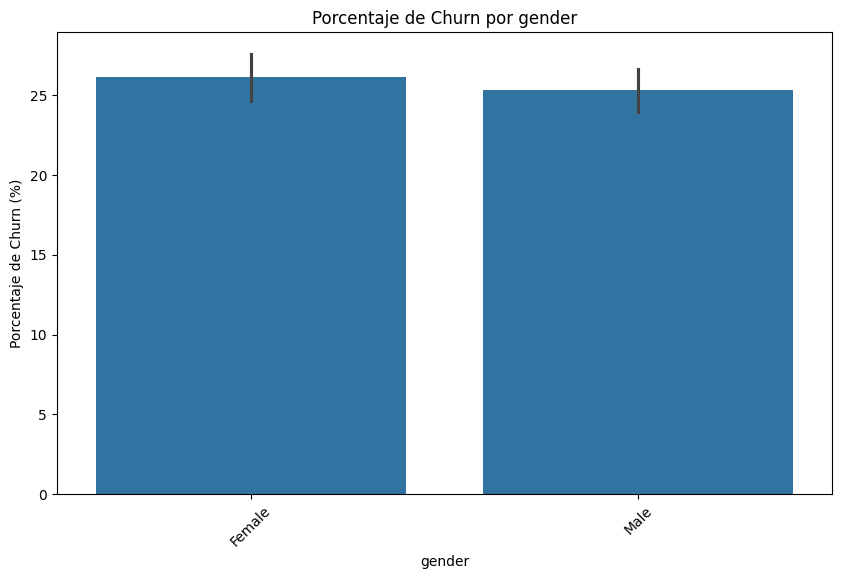

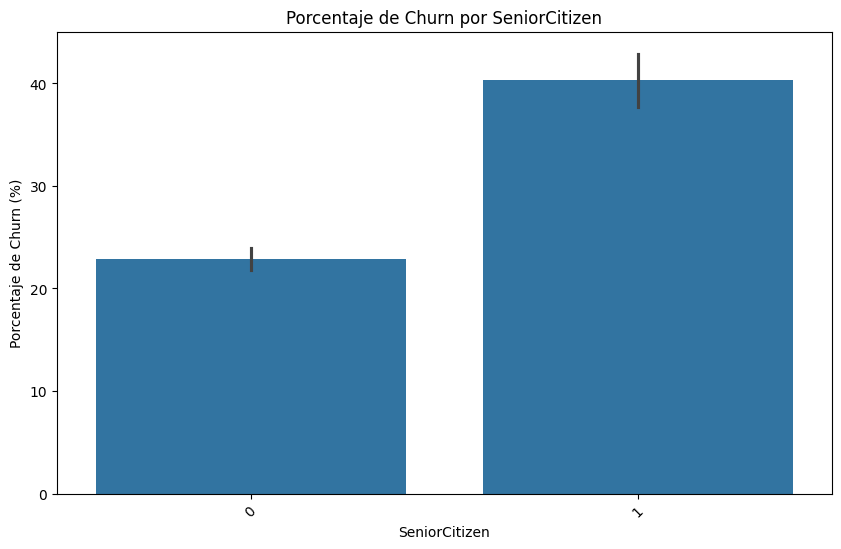

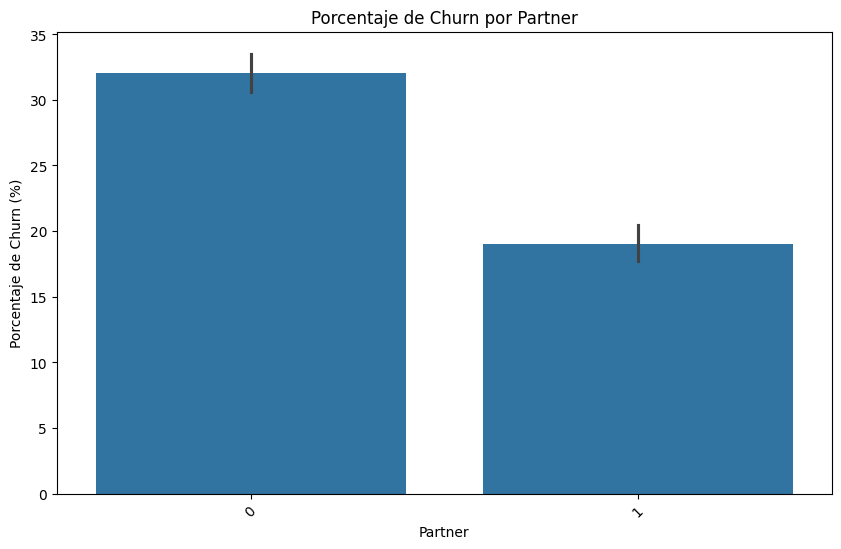

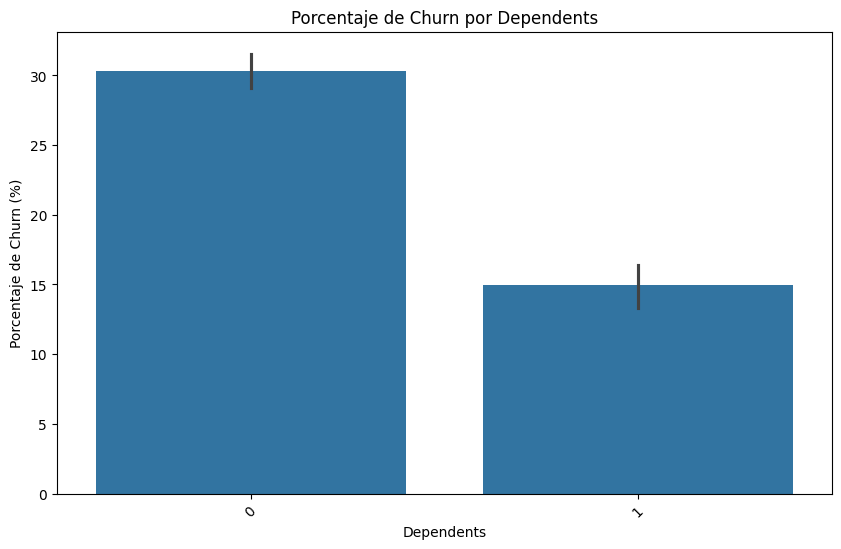

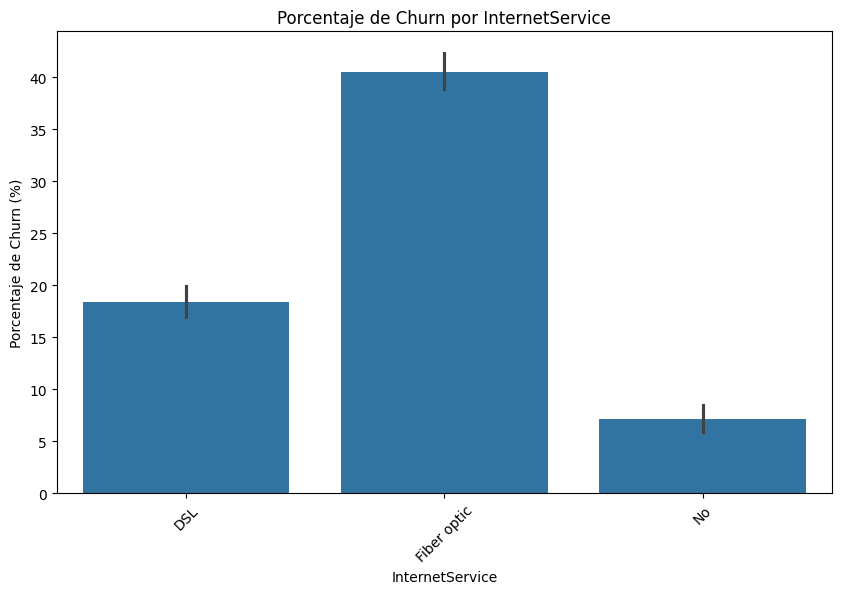

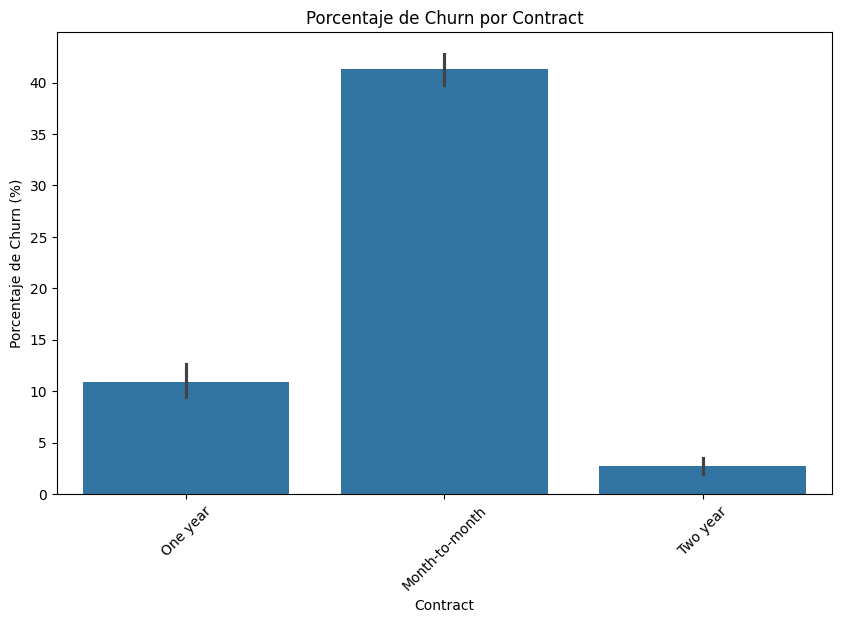

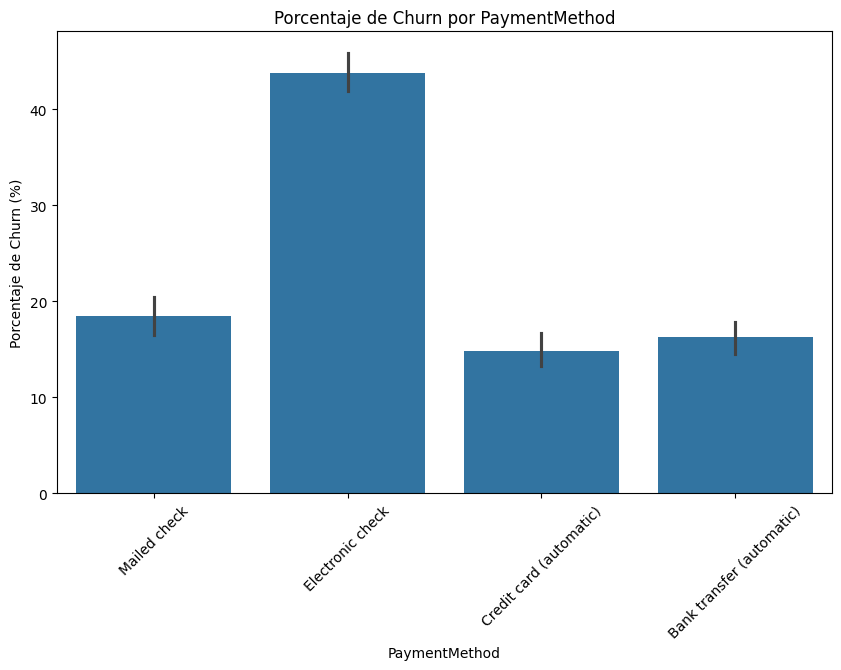

In [7]:
# Función para graficar Churn por categoría
def plot_churn_by_category(category):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=category, y='Churn', data=df, estimator=lambda x: sum(x)*100/len(x))
    plt.title(f'Porcentaje de Churn por {category}')
    plt.ylabel('Porcentaje de Churn (%)')
    plt.xticks(rotation=45)
    plt.show()

# Graficar para las principales categorías
plot_churn_by_category('gender')
plot_churn_by_category('SeniorCitizen')
plot_churn_by_category('Partner')
plot_churn_by_category('Dependents')
plot_churn_by_category('InternetService')
plot_churn_by_category('Contract')
plot_churn_by_category('PaymentMethod')

**2.4. Churn por variables numéricas**

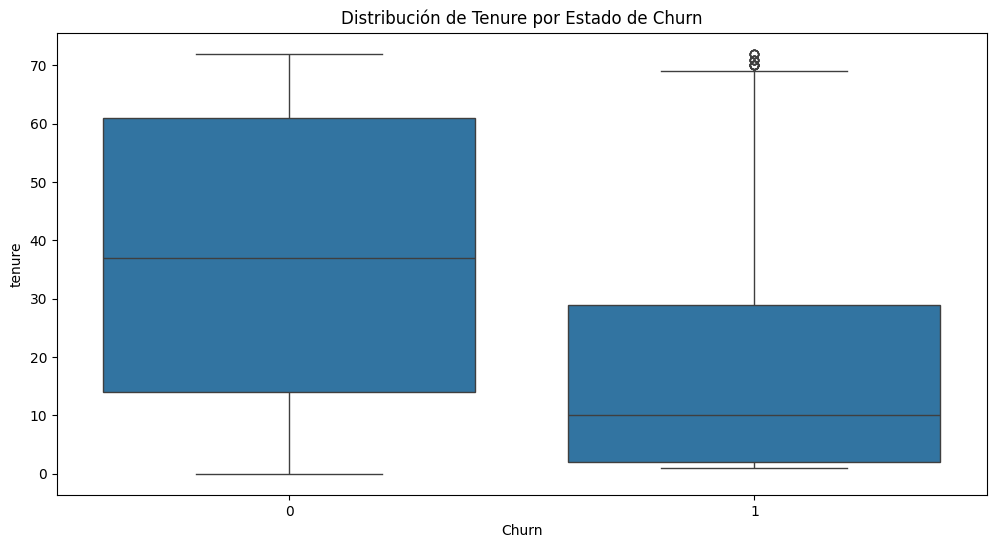

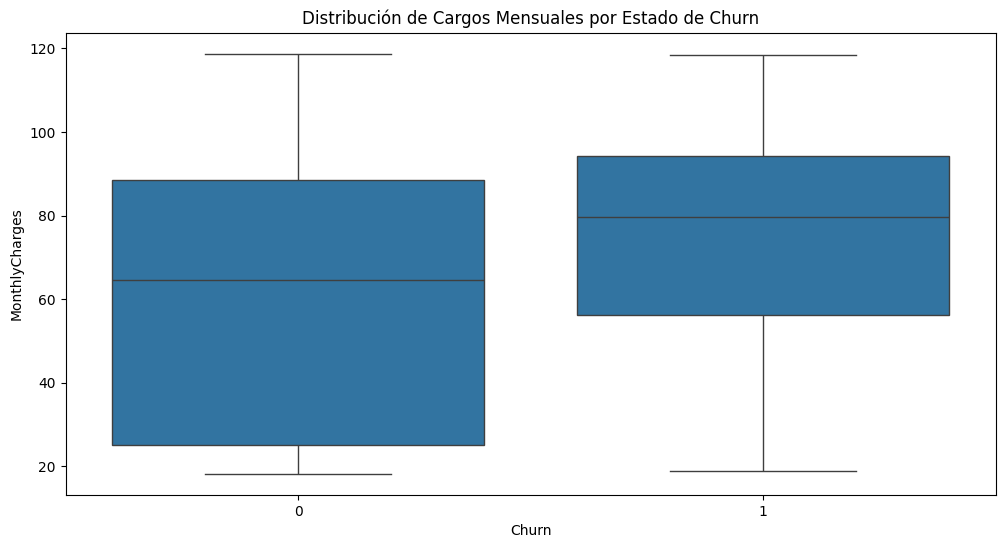

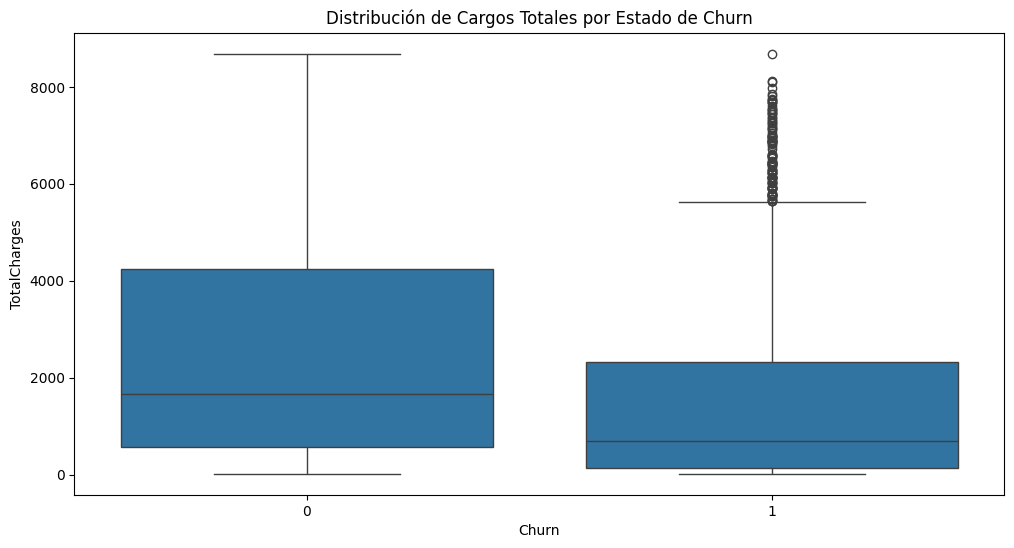

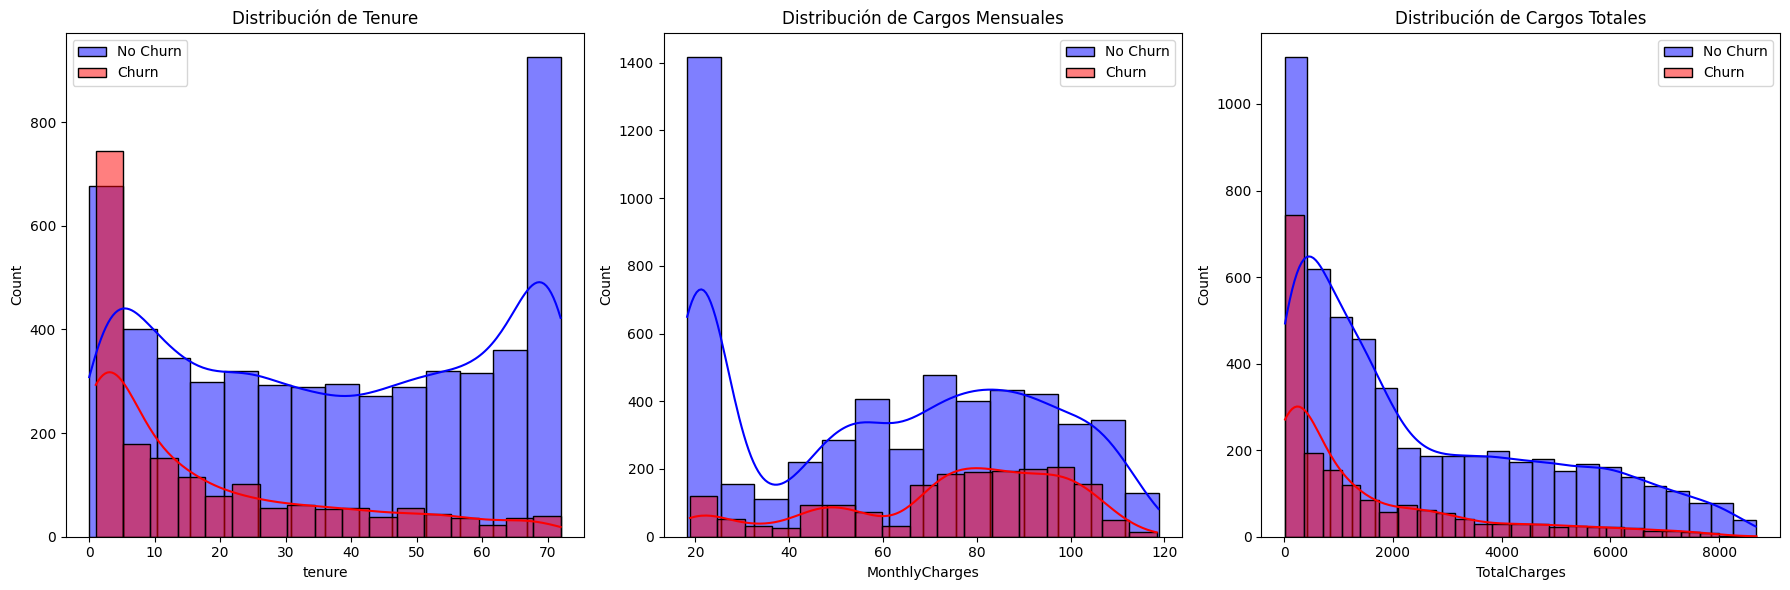

In [8]:
# Boxplots para variables numéricas vs Churn
plt.figure(figsize=(12, 6))
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Distribución de Tenure por Estado de Churn')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Distribución de Cargos Mensuales por Estado de Churn')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Churn', y='TotalCharges', data=df)
plt.title('Distribución de Cargos Totales por Estado de Churn')
plt.show()

# Histogramas comparativos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.histplot(df[df['Churn']==0]['tenure'], kde=True, color='blue', label='No Churn', ax=axes[0])
sns.histplot(df[df['Churn']==1]['tenure'], kde=True, color='red', label='Churn', ax=axes[0])
axes[0].set_title('Distribución de Tenure')
axes[0].legend()

sns.histplot(df[df['Churn']==0]['MonthlyCharges'], kde=True, color='blue', label='No Churn', ax=axes[1])
sns.histplot(df[df['Churn']==1]['MonthlyCharges'], kde=True, color='red', label='Churn', ax=axes[1])
axes[1].set_title('Distribución de Cargos Mensuales')
axes[1].legend()

sns.histplot(df[df['Churn']==0]['TotalCharges'], kde=True, color='blue', label='No Churn', ax=axes[2])
sns.histplot(df[df['Churn']==1]['TotalCharges'], kde=True, color='red', label='Churn', ax=axes[2])
axes[2].set_title('Distribución de Cargos Totales')
axes[2].legend()

plt.tight_layout()
plt.show()

## **3. Conclusiones e Insights**

Principales hallazgos:
Tasa de Churn general: El X% de los clientes abandonaron el servicio (valor exacto depende de los datos).

Factores asociados con mayor Churn:

Clientes con servicio de Fibra óptica tienen mayor tasa de Churn.

Contratos mes a mes muestran mayor abandono que contratos anuales o bianuales.

Métodos de pago como cheque electrónico están asociados con mayor Churn.

Clientes sin dependientes y sin pareja tienen mayor probabilidad de abandonar.

Clientes seniors (mayores de 65 años) muestran mayor tasa de Churn.

Relación con variables numéricas:

Clientes con menor tiempo de permanencia (tenure) tienen mayor probabilidad de Churn.

Aunque los cargos mensuales son más altos para clientes que abandonan, los cargos totales son más bajos, lo que sugiere que abandonan pronto.

Servicios adicionales:

Clientes sin servicios adicionales como seguridad online, backup, soporte técnico, etc., tienen mayor tasa de Churn.

4. Recomendaciones Estratégicas
Focalizar en clientes de alto riesgo:

Clientes nuevos (poco tiempo de permanencia).

Clientes con contratos mes a mes.

Clientes con servicio de fibra óptica.

Incentivar contratos a largo plazo:

Ofrecer descuentos o beneficios adicionales para clientes que elijan contratos anuales o bianuales.

Mejorar retención de clientes con fibra óptica:

Investigar causas del alto Churn en este segmento (¿problemas de servicio? ¿expectativas no cumplidas?).

Ofrecer soporte técnico proactivo.

Promover servicios adicionales:

Los clientes con más servicios adicionales muestran menor Churn. Paquetes combinados podrían mejorar retención.

Programas de fidelización:

Para clientes seniors y aquellos sin dependientes, que muestran mayor propensión a abandonar.

Mejorar experiencia con cheque electrónico:

Investigar por qué este método de pago está asociado con mayor Churn y tomar acciones correctivas.

Monitorear cargos mensuales:

Asegurar que los incrementos en cargos mensuales estén justificados y bien comunicados para evitar sorpresas.

5. Análisis Adicional (Opcional)
Para un análisis más profundo, se recomienda:

Segmentación de clientes:

Agrupar clientes con características similares para estrategias personalizadas.

Modelado predictivo:

Desarrollar un modelo para predecir probabilidad de Churn y actuar preventivamente.

Análisis de cohortes:

Estudiar el comportamiento de grupos de clientes que se registraron en el mismo período.

Encuestas de satisfacción:

Complementar datos cuantitativos con feedback cualitativo de clientes que abandonaron.

Este análisis proporciona una base sólida para entender los factores que influyen en el Churn y tomar acciones estratégicas para mejorar la retención de clientes en Telecom X.

